# Gender Classification

## Prediction Test

Test to predict based on real random images

In [1]:
import torch
from PIL import Image
from torchvision import models
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import requests
from io import BytesIO
import os
import matplotlib.pyplot as plt

model_path = './Models'

# Image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_image(image_path_or_url):
    """Improved image loading with better error handling"""
    try:
        if image_path_or_url.startswith(('http://', 'https://')):
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
                'Accept': 'image/webp,image/apng,image/*,*/*;q=0.8'
            }
            session = requests.Session()
            response = session.get(image_path_or_url, 
                                 headers=headers, 
                                 stream=True, 
                                 timeout=10)
            response.raise_for_status()
            
            # Verify content is actually an image
            if 'image' not in response.headers.get('Content-Type', ''):
                raise ValueError("URL does not point to an image")
                
            img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            img = Image.open(image_path_or_url).convert('RGB')
        return img
    except requests.exceptions.RequestException as e:
        raise ValueError(f"URL error: {str(e)}")
    except IOError as e:
        raise ValueError(f"Image loading error: {str(e)}")
    except Exception as e:
        raise ValueError(f"Unexpected error: {str(e)}")

def predict_image(model, image_path_or_url):
    try:
        # Load and preprocess the image
        img = load_image(image_path_or_url)
        img_tensor = preprocess(img)
        img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
        
        # Make prediction
        with torch.no_grad():
            outputs = model(img_tensor)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted_class = torch.max(outputs, 1)
        
        # Get results
        class_labels = ["female", "male"]
        predicted_label = class_labels[predicted_class.item()]
        confidence = probabilities[0][predicted_class.item()].item()
        
        # Display image and prediction
        plt.figure(figsize=(3, 2))
        plt.imshow(img)
        plt.title(f"Prediction: {predicted_label} ({confidence*100:.2f}% confidence)")
        plt.axis('off')
        plt.show()
        
        return {
            predicted_label,
            confidence,
            True
        }
    
    except Exception as e:
        return {
            'error': str(e),
            'success': False
        }

In [2]:
def googlenet_pt():
    map_location = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Model setup (same as before)
    model_name = 'GoogleNet Pre-Trained with ImageNet Dataset'
    model_state_weight = 'googlenet_pt_5k_best.pth'
    
    model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)  # replace with your actual model, e.g., models.resnet18()
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)  # for 2 output classes: male/female
    try:
        checkpoint = torch.load(os.path.join(model_path, model_state_weight), map_location, weights_only=True)
    except:
        # Fallback for older PyTorch versions or complex checkpoints
        checkpoint = torch.load(os.path.join(model_path, model_state_weight))
    model.load_state_dict(checkpoint['model'])
    
    model.eval()
    return model
    
def resnet18_pt():
    map_location = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Model setup (same as before)
    model_name = 'ResNet18 Pre-Trained with ImageNet Dataset'
    model_state_weight = 'resnet18_pt_5k_best.pth'
    
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # replace with your actual model, e.g., models.resnet18()
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)  # for 2 output classes: male/female
    try:
        checkpoint = torch.load(os.path.join(model_path, model_state_weight), map_location, weights_only=True)
    except:
        # Fallback for older PyTorch versions or complex checkpoints
        checkpoint = torch.load(os.path.join(model_path, model_state_weight))
    model.load_state_dict(checkpoint['model'])
    
    model.eval()
    return model
    
def vgg16_pt(): 
    map_location = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Model setup (same as before)
    model_name = 'Vgg16 Pre-Trained with ImageNet Dataset'
    model_state_weight = 'vgg16_pt_5k_best.pth'
    
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)  # replace with your actual model, e.g., models.resnet18
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)  # for 2 output classes: male/female
    try:
        checkpoint = torch.load(os.path.join(model_path, model_state_weight), map_location, weights_only=True)
    except:
        # Fallback for older PyTorch versions or complex checkpoints
        checkpoint = torch.load(os.path.join(model_path, model_state_weight))
    model.load_state_dict(checkpoint['model'])
    
    model.eval()
    return model

### Prediction

GoogleNet


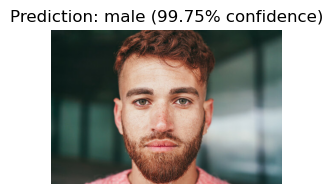


ResNet18


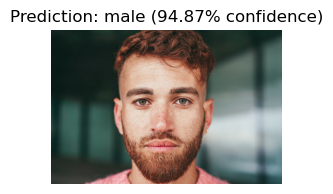


VGG16


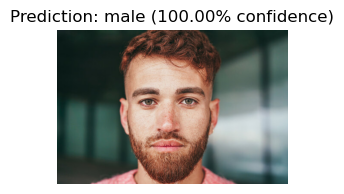

{0.9999899864196777, True, 'male'}

In [3]:
# local_image = "test_image.jpg"  # Local file path
url_image = "https://t4.ftcdn.net/jpg/05/30/01/09/360_F_530010960_WkmW6q8FIZ42LkEQoSRCLTNTw0WgJqKY.jpg"  # Image URL

print('GoogleNet')
predict_image(googlenet_pt(),url_image)

print()
print('ResNet18')
predict_image(resnet18_pt(),url_image)

print()
print('VGG16')
predict_image(vgg16_pt(), url_image)

GoogleNet


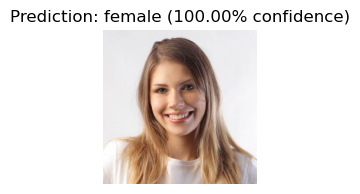


ResNet18


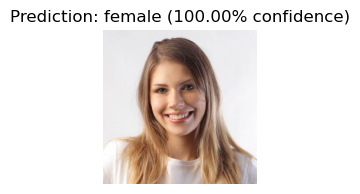


VGG16


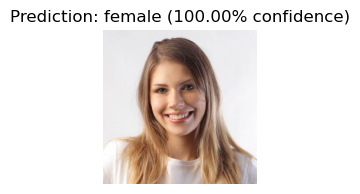

{1.0, 'female'}

In [4]:
url_image = "https://www.kieranjameswalker.com/wp-content/uploads/2016/07/person_sample_2-1.jpg"

print('GoogleNet')
predict_image(googlenet_pt(),url_image)

print()
print('ResNet18')
predict_image(resnet18_pt(),url_image)

print()
print('VGG16')
predict_image(vgg16_pt(), url_image)

GoogleNet


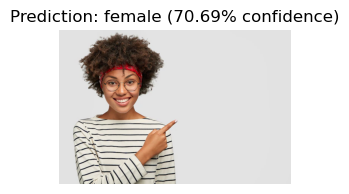


ResNet18


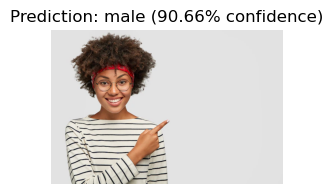


VGG16


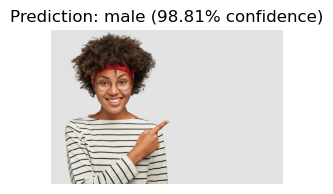

{0.9881446361541748, True, 'male'}

In [5]:
url_image = "https://img.freepik.com/free-photo/happy-delighted-freelancer-with-afro-hairstyle_273609-17851.jpg"

print('GoogleNet')
predict_image(googlenet_pt(),url_image)

print()
print('ResNet18')
predict_image(resnet18_pt(),url_image)

print()
print('VGG16')
predict_image(vgg16_pt(), url_image)